<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/6_Generation_Classification_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [83]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [84]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
        
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [85]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

filepath = '/content/gdrive/MyDrive/Datascience/PFE/transformer_model.h5'
model = load_model(filepath, compile=False)

In [86]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

## 1. Generation of the new data

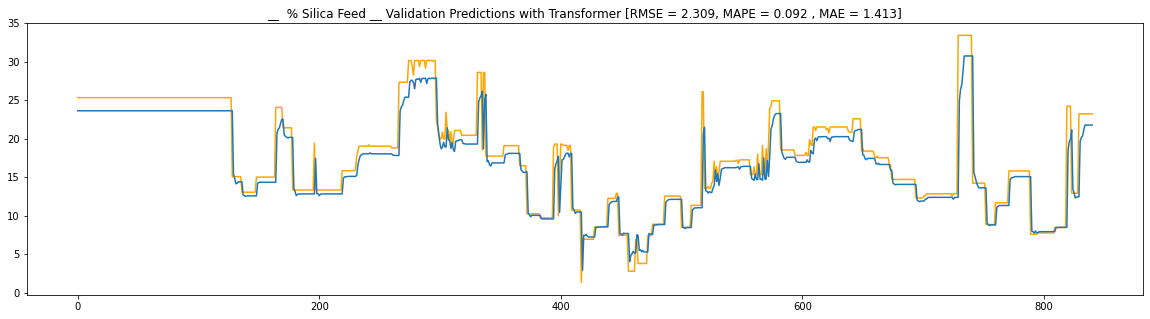

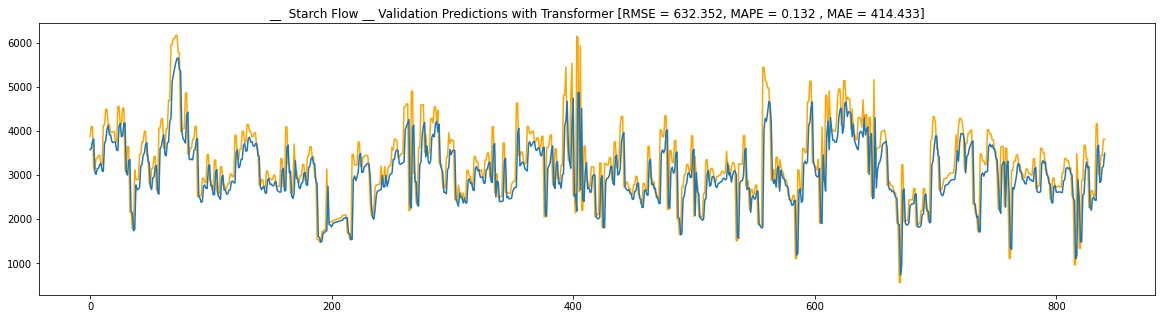

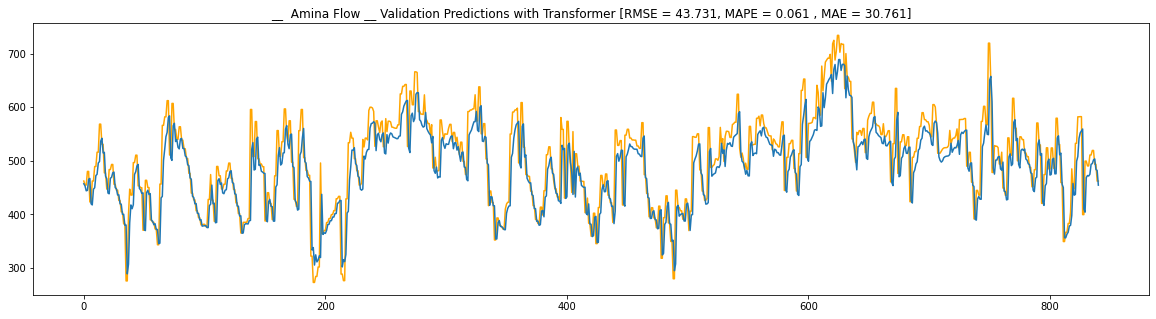

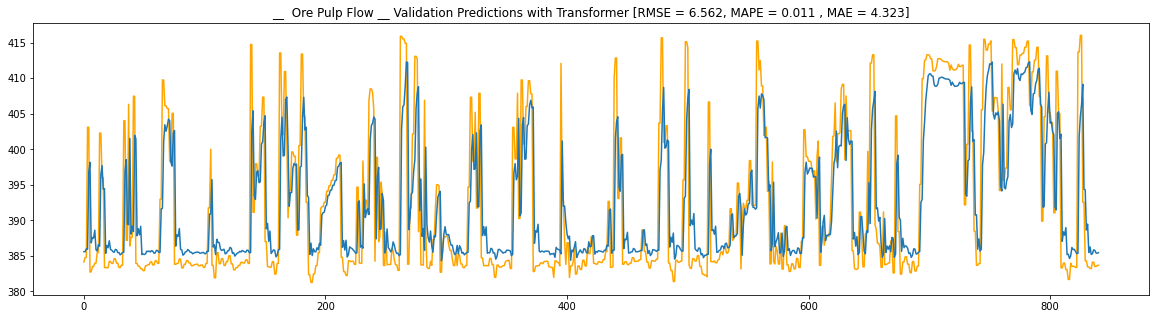

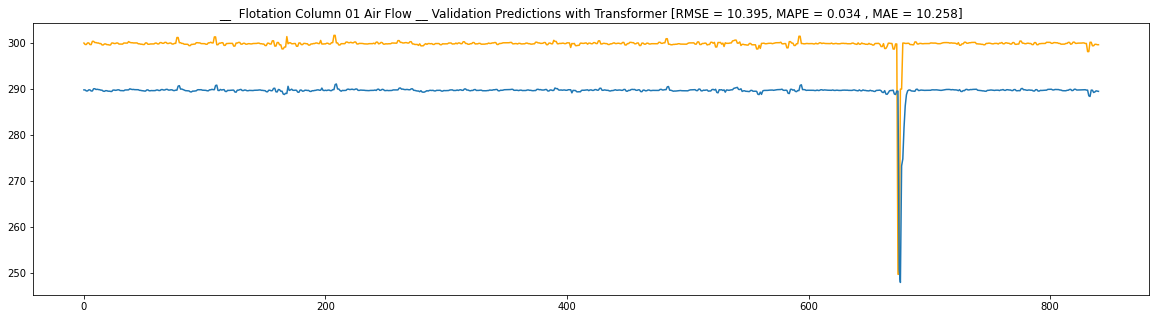

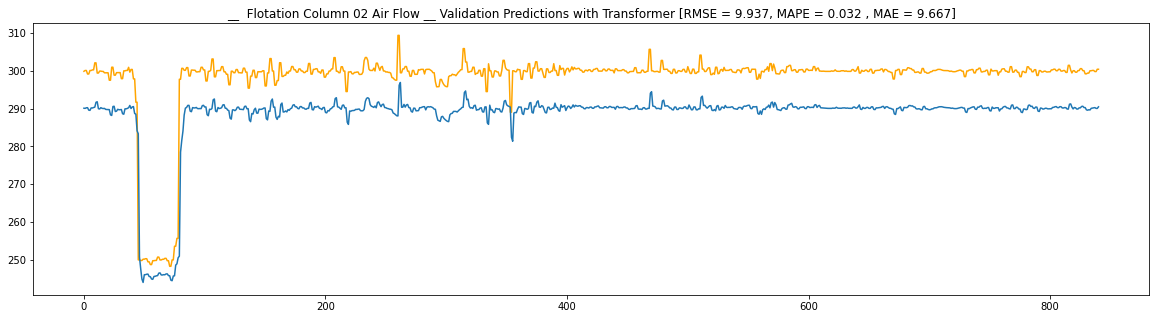

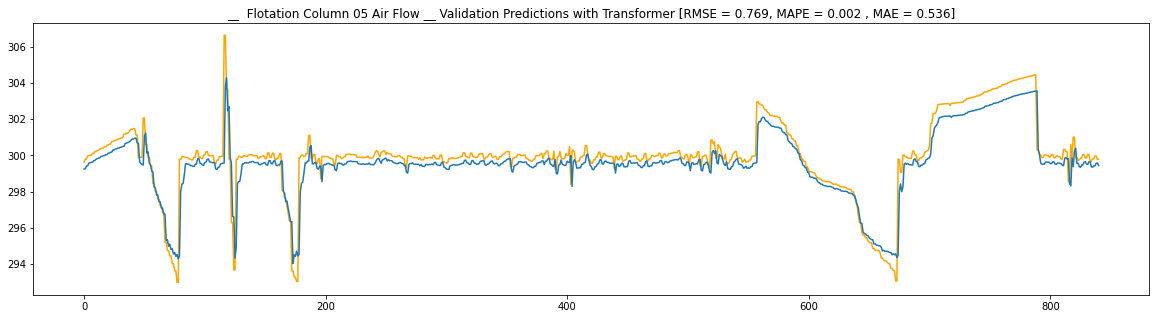

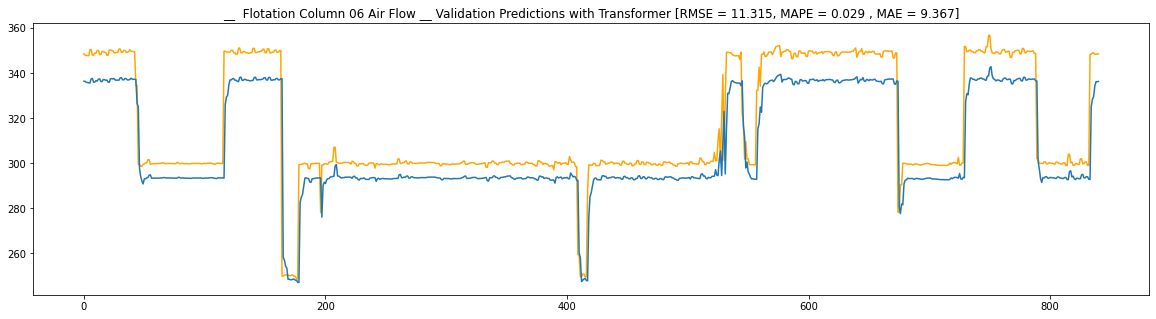

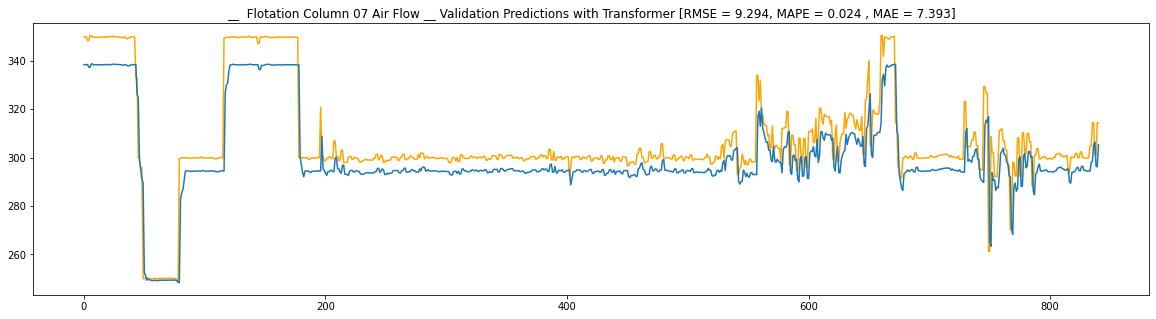

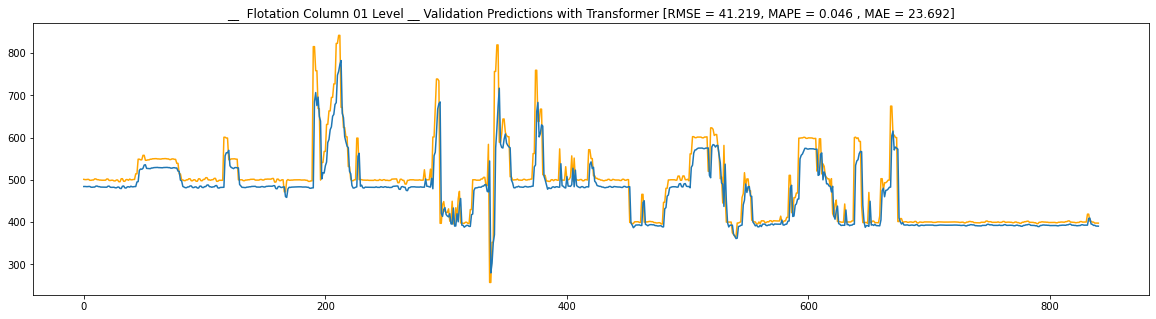

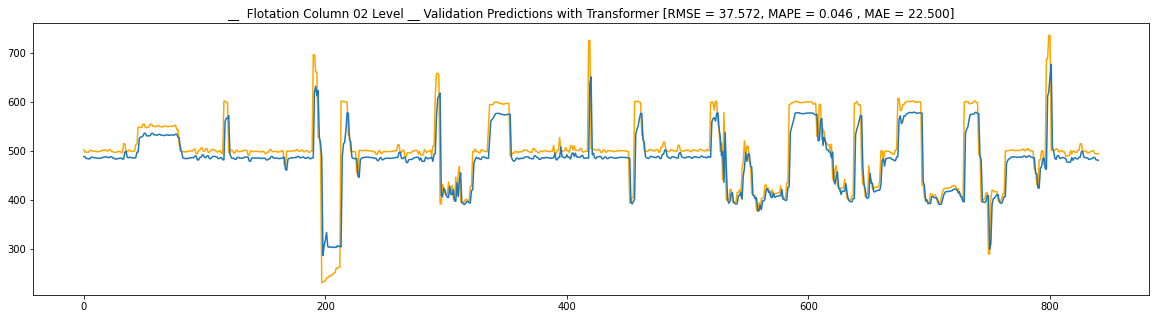

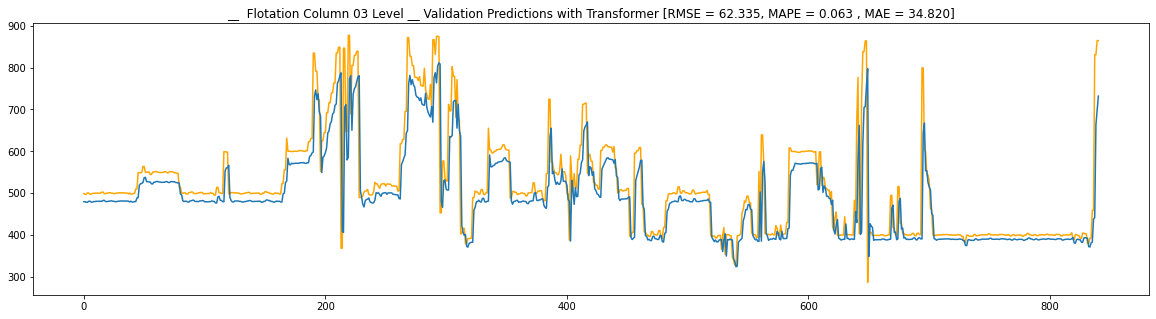

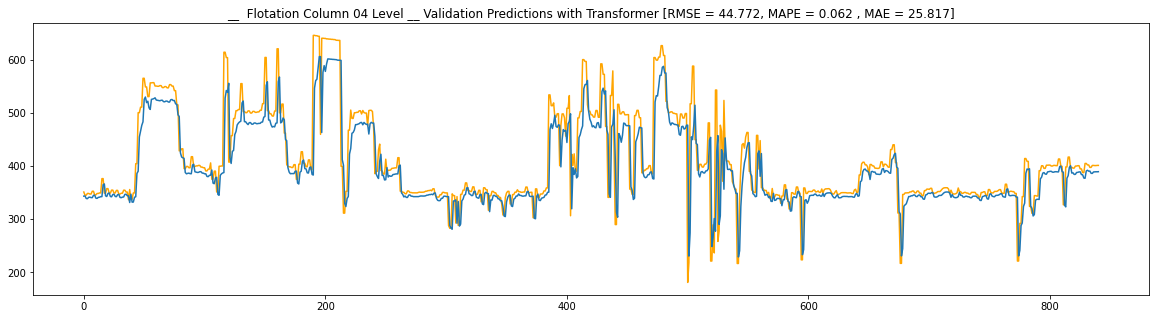

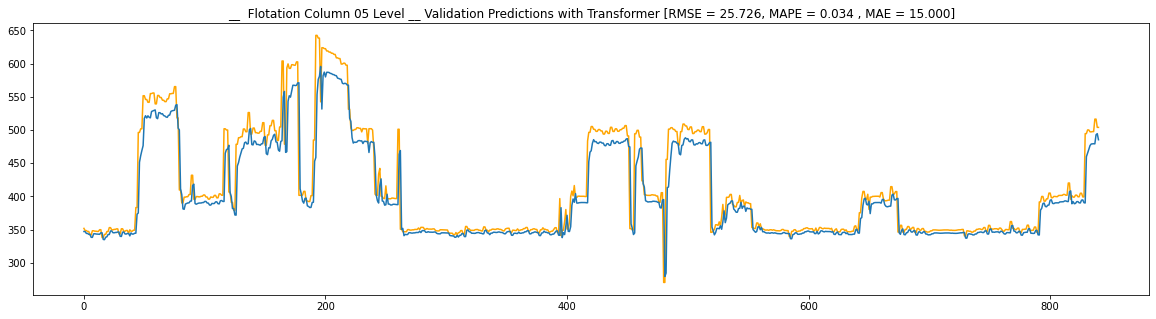

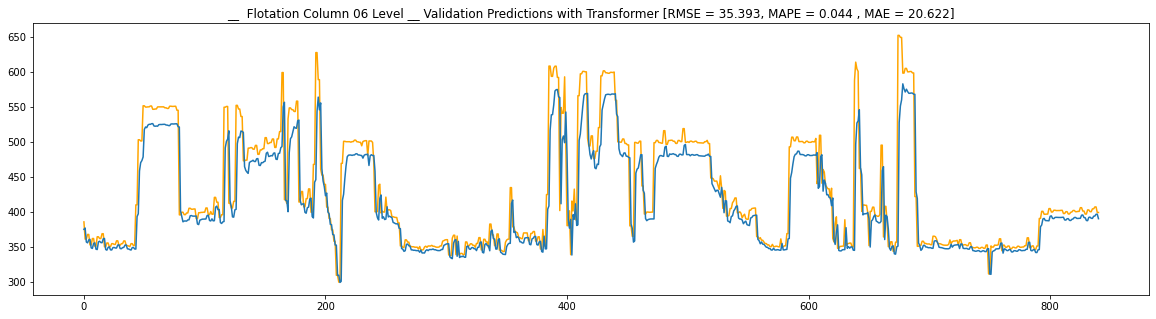

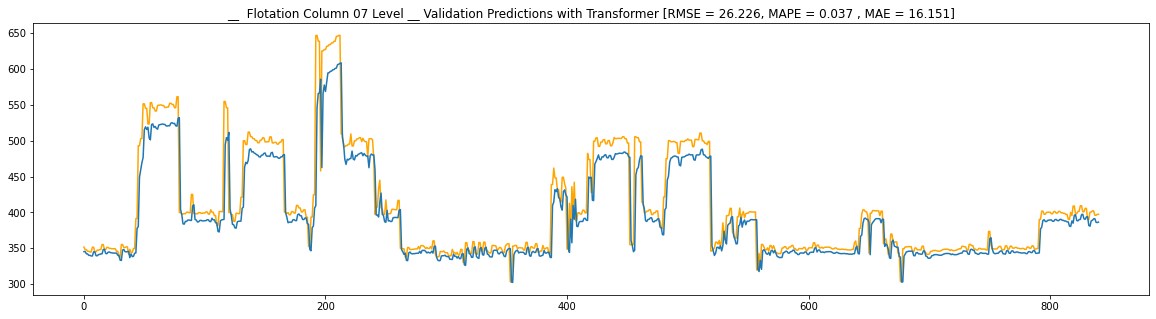

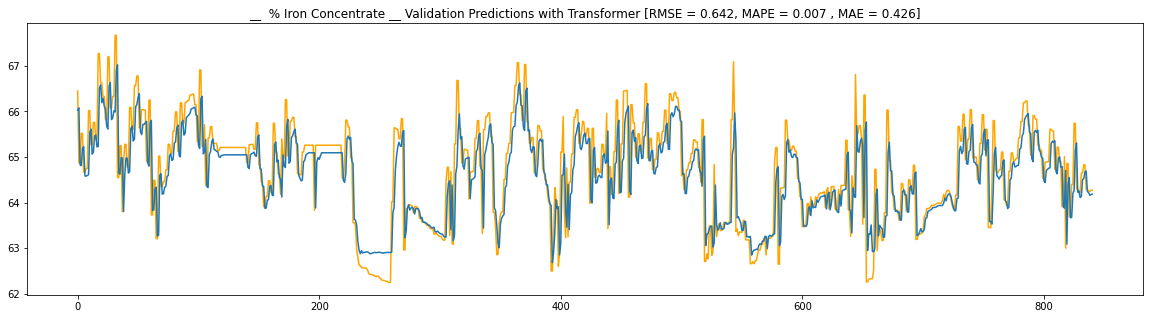

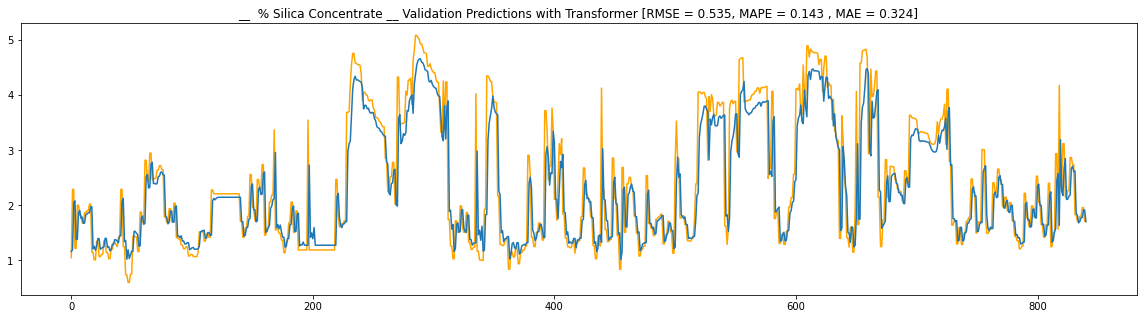

In [87]:
from pandas._libs.lib import count_level_2d
from sklearn.preprocessing import MinMaxScaler

new_data = []
predictions = []
final_df = pd.DataFrame(new_data)
i = -1

for col in df.columns:
  # Normalization
  values = df[[col]].values

  # Normalization
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(values)

  WINDOW_SIZE = 5

  time_series = scaled_data;
  data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

  # 70% 15% 15%

  X_train_tr, y_train_tr = X[:3935], y[:3935]
  X_test, y_test = X[3935:4775], y[3935:4775]
  X_val, y_val = X[4775:], y[4775:]

  import tensorflow as tf 

  BATCH_SIZE = 256
  BUFFER_SIZE = 10000

  train_univariate = tf.data.Dataset.from_tensor_slices((X_train_tr, y_train_tr))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

  # reshape input to be 3D [samples, timesteps, features]
  X_train_tr = X_train_tr.reshape((X_train_tr.shape[0], WINDOW_SIZE,1))
  X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
  X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
      

  y_pred_val = model.predict(np.asarray(X_val).astype('float32'))
  Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

  Inverse_y_val = y_val.reshape(-1,1)
  Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
  
  Inverse_X_val = X_val.reshape(-1,1)
  Inverse_X_val = scaler.inverse_transform(Inverse_X_val)

  
  new_col = []
  for val in Inverse_y_pred_val:
    new_col.append(val[0])

  final_df.insert(i+1,col ,new_col)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

  fig, ax = plt.subplots(figsize=(20,5))
  plt.plot(Inverse_y_val, color='orange')
  plt.plot(Inverse_y_pred_val)
  plt.title("__  %s __ Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (col, rmse, mape, mae) )
  plt.show()

In [88]:
def create_time_steps(length):
    return list(range(-length, 0))
    
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i]);
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step');
    
    return plt

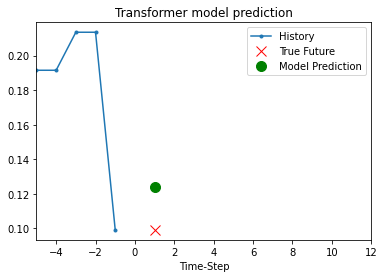

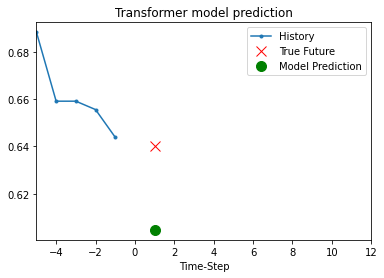

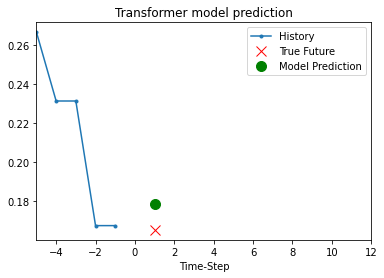

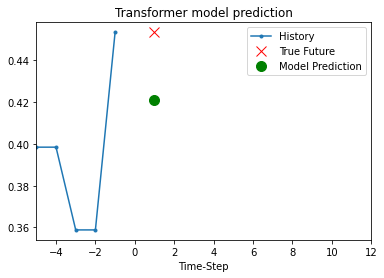

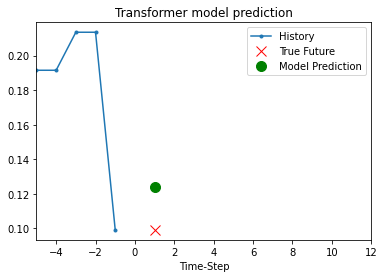

In [89]:
for x, y in val_univariate.take(5):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 1, 'Transformer model prediction')
    plot.show()

## 2. Classification

In [92]:
for col in final_df:
  final_df[col] =final_df[col].apply(lambda x: round(x, 3))

In [91]:
import pickle

filename = '/content/gdrive/MyDrive/Datascience/PFE/knn_classifier.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#for testing
if {'Purity prediction'}.issubset(df.columns): 
  final_df.drop('Purity prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(final_df)
result = loaded_model.predict(X_val)

final_df.insert(0,"Purity prediction" ,result)
final_df.head()

,Purity prediction,% Silica Concentrate,% Iron Concentrate,Flotation Column 07 Level,Flotation Column 06 Level,Flotation Column 05 Level,Flotation Column 04 Level,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 01 Level,Flotation Column 07 Air Flow,Flotation Column 06 Air Flow,Flotation Column 05 Air Flow,Flotation Column 02 Air Flow,Flotation Column 01 Air Flow,Ore Pulp Flow,Amina Flow,Starch Flow,% Silica Feed
0,1,1.162,66.027,345.339,374.949,347.078,343.339,479.532,488.517,484.339,338.419,336.494,299.252,290.083,289.834,385.598,457.146,3571.075,23.605
1,1,1.193,66.079,345.371,376.699,346.973,343.723,479.554,488.635,484.453,338.422,336.409,299.264,290.046,289.812,385.592,453.200,3602.036,23.605
2,1,2.052,64.830,342.337,356.705,344.198,338.928,478.196,484.950,484.119,338.463,335.975,299.411,290.194,289.597,385.992,444.029,3765.490,23.605
3,1,2.083,64.809,342.141,355.535,344.132,338.573,478.075,484.681,484.076,338.469,335.920,299.425,290.220,289.604,385.936,444.793,3816.331,23.605
4,1,1.378,65.187,340.122,359.729,342.796,341.080,480.585,484.086,484.424,337.416,335.755,299.574,289.571,289.836,396.805,465.571,3063.480,23.605


## 3. Interpretation

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.

LIME interpretation : https://github.com/marcotcr/lime

('Starch Flow <= 2203.11', 0.007104066221272916), <br>
 ('Flotation Column 07 Level > 458.47', -0.004605988469347347),<br>
 ('Flotation Column 06 Level > 491.77', 0.004127897872587883),<br>
 ('Flotation Column 04 Level > 495.48', -0.004090657038231922),<br>
 ('Flotation Column 05 Level > 496.74', -0.00378142401879994),<br>
 ('Flotation Column 03 Level > 599.96', -0.003148344924666014),<br>
 ('Flotation Column 01 Level > 599.53', -0.0022314225278253588),<br>
 ('Flotation Column 02 Level > 598.76', -0.0017148367099924105),<br>
 ('Flotation Column 07 Air Flow > 300.09', 0.0016578746700500096),<br>
 ('% Silica Concentrate <= 1.42', 0.0016517897495015802)

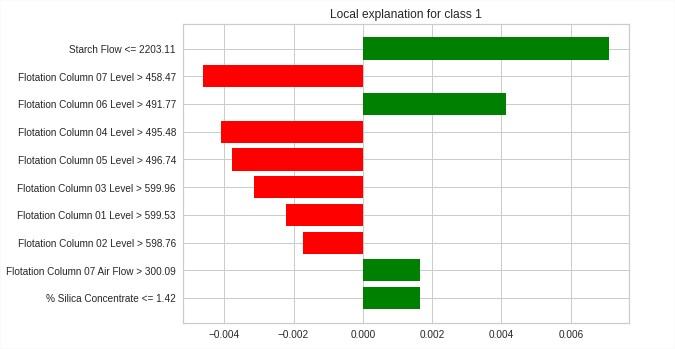 <br> 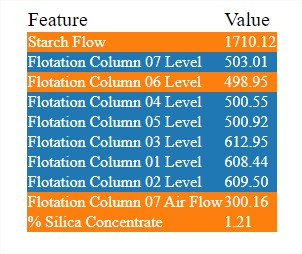<br>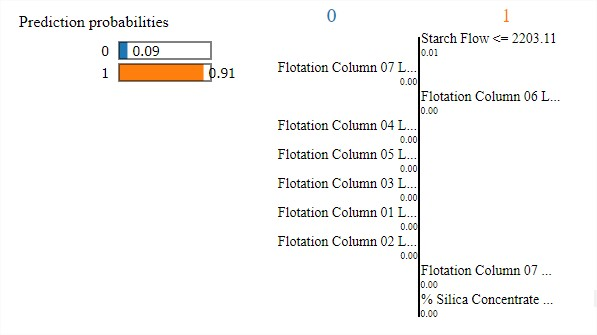